# MNIST digits classification with TensorFlow

In [1]:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
# please, uncomment the week you're working on
# setup_google_colab.setup_week1()
setup_google_colab.setup_week2()

shred: setup_google_colab.py: failed to open for writing: No such file or directory
--2020-02-07 16:23:11--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3636 (3.6K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.55K  --.-KB/s    in 0s      

2020-02-07 16:23:11 (99.7 MB/s) - ‘setup_google_colab.py’ saved [3636/3636]

**************************************************
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
**************************************************
cifar-10-batches-py.tar.gz
**************************************************
mnist.npz


# MNIST digits classification with TensorFlow

In [2]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow as tf
print("We're using TF", tf.__version__)

import sys
sys.path.append("../..")
import grading

import matplotlib_utils
from importlib import reload
reload(matplotlib_utils)

import grading_utils
reload(grading_utils)

import keras_utils
from keras_utils import reset_tf_session


We're using TF 1.15.0


Using TensorFlow backend.


## Look at the data

We have 50000 28x28 images of digits from 0 to 9. We will train a classifier on this data

In [0]:
import preprocessed_mnist

In [5]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocessed_mnist.load_dataset()

 7290880/11490434 [==================>...........] - ETA: 0s

X_train [shape (50000, 28, 28)] sample patch: 
 [[0.         0.29803922 0.96470588 0.98823529 0.43921569]
 [0.         0.33333333 0.98823529 0.90196078 0.09803922]
 [0.         0.33333333 0.98823529 0.8745098  0.        ]
 [0.         0.33333333 0.98823529 0.56862745 0.        ]
 [0.         0.3372549  0.99215686 0.88235294 0.        ]]
 A closedup of a sample patch: 


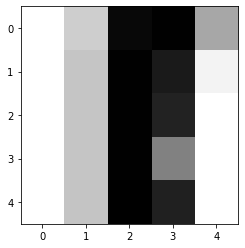

And the whole sample:


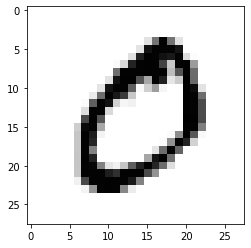

y_train[shape (50000,)] 10 samples: 
 [5 0 4 1 9 2 1 3 1 4]


In [7]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch: \n" %(str(X_train.shape)),X_train[1,15:20,5:10])
print(" A closedup of a sample patch: ")
plt.imshow(X_train[1,15:20,5:10],cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1],cmap="Greys")
plt.show()
print("y_train[shape %s] 10 samples: \n" %(str(y_train.shape)),y_train[:10])

## Linear model



*   Flatten the images (28x28 -> 784) with X_train.reshape((X_train.shape[0],-1)) to simplify our linear mode implementation
*   Use a matrix place holder for flattened X_train
*   Convert y_train to one-hot encoded vectros that are needed for cross-entropy
*   Used a shared variable W for all weights and b for all biases
*   Aim for ~0.93 validation accuracy

In [8]:
X_train_flat = X_train.reshape((X_train.shape[0],-1))
print(X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0],-1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [9]:
import keras

y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val,10)

print(y_train_oh.shape)
print(y_train_oh[:3],y_train[:3])

(50000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


In [10]:
# run this again if you remake your graph
s = reset_tf_session()

In [0]:
# Model parameters: W and b
W = tf.get_variable("W",shape=(784,10),dtype=tf.float32,trainable=True)
b = tf.get_variable("b",shape=(10,),dtype=tf.float32)

In [0]:
# Placeholders for the input data
input_X = tf.placeholder(tf.float32,shape=(None,784))
input_y = tf.placeholder(tf.float32,shape=(None,10))

In [14]:
# compute predictions
logits = input_X@W+b
# apply tf.nn.softmax to logits
probas = tf.nn.softmax(logits)
# apply tf.argmax to find a class index with highest probability
classes = tf.argmax(probas,1)
# cross-entropy loss
loss =tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = input_y,logits=logits))
# use a default tf.train.AdamOptimizer to get an SGD step
step = tf.train.AdamOptimizer().minimize(loss) #optimizer step that minimizes the loss

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [15]:

s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvPfjt%2B1J8FP2b5NGsfil4g1Maj4ilnTQNB8OeF9R1zVNR8lVed4bHTbee5kjiVkMkixlI96biu5c%2BhV4N%2B0P8D/j5/wANJ%2BDv2tv2bLLwfrWueH/B2seFNX8KeOdcutLtLywv7mwuxcQXtraXj288U2noCpt3WVJSCUKK1ABpf/BTL9izWLvxPb2nxXv0h8FWsk/jLUrvwXrEFjoIS0iu9l5dy2iwWsrQzRskMjrJIWKorMrKL2n/APBQ/wDZK1HwBrXxFTx/q9vB4f1ay0vVdE1DwNrNrrkV5ebfscC6PNaLqEr3AYGER27eaAxTcFYjy2b9gH4y%2BMf2a/jn8NfGHinwppHin4o/FS38daHc6U1xeWFpeW0OiywQ3IkihkkiN3pRRwoyYHGDuJVaPi79i/8AaV%2BLmr/Ef45fG34S/CjWvFnjWx8KaPp/gKy%2BI2s2Wm6fY6Hcaldw3qa7b6al5DqDXOqTOksVoPJSKNFZiWcgHsviH9vv9mzwv4a8OeI9XvvG3meK0v5NE8P2vwm8SXGuSRWUscV3NJpMWntf28MLzQq8s0CIpmiy37xM%2Bmaz8RPBHhv4e3XxX8T%2BJbbSvDljo76rf6vqrfZYbSySIzPPMZdvlKsYLNvxtAOcYNfGHin9hH9s/WPgX4X8Nay3hfxV470a58RHRfGV/wDHbxNpGr%2BCLW%2BuUktLO11q1sJLzXIYkjhEy3qw/aTbReYCFGPUfjR/wTotfj1%2Bzb4n%2BHHxD%2BOfjW78d%2BMPhfH4Z17xS3jbWho818tpDE2oJoS3y2FuzzQLK3kRRSEPIBIrSM5AOkg/4KUfsZf8K58V/FbWPite6Jo3giysr7xQ/ifwdq%2Bk3NlZXkxhtb37LeWsVxJaSyK6pcxxtC3luQ%2BEYjj/AI3f8FZP2d/hn8ENU%2BMfgPRfFXiqbQfiD4X8L674Y/4QXXbHU7A6zqVrax3T2cmnNdeV5Fw88DeT5d48aW8MhknjB8r1T/gmJ8ZPHfwq8faR4i8DeG9G8Y%2BI9D0fR7DxDqv7RfjPxut3aWusW%2BoTRyf27AfsEZ8likUSzHe%2BGkxknv8A9qH9gz40/GD4g/F/4g%2BBfEPheOTxfB8LbzwlZ6tfXMSvf%2BE/EdzrUsN40dvJ5ENwGt4VljEzrl2MfyKrgHqFh/wUE/Zb1H4m2XwZh8T%2BJo/Fd5oun6xLoF38N9egudO0%2B9adILu/SSyU6dDut5VeS68pYiFEhQum6j4a/wCCmH7FPi3wZ4s%2BIWkfGC4TR/Bfgi68Zaxe6h4S1W0Fx4et0Z5tWsVntUbVLNVQ4nsxPGxZArEugbB0P9kP4ofEP4mfG74g/G9fD2gxfGj4O%2BHfCF1Y%2BE9duNRl0u4tE11Ltlnns7XzYwNViMT7FZikm6OPA3fN37Y37Kn7UOj/ALDHxS%2BJv7TF34AtIfhD%2BxT8QfBHhePwFqF5cNrzXukWxn1G6W5toBYqE0i3CWcbXAVppCZ22oKAPrPw9/wUl/Yy8TaHrHiPT/i1dQWehppU1/JqnhLVbJmtNSu1s7HUIUuLVGubCWdgovoQ9qoDO0qorMPT9E%2BLvw88R/FLX/gvofiH7T4k8LaXp%2Boa/YR2k22zgvmuBa7pinlF3%2ByzHy1cyKoRmVVkjLfJOofsz%2BIPFegeKfjb/wAFIvF/wz8J%2BBbf9nu5%2BHUlx4f8QTLay6beyQyXmq3k17BbpYOTBbCG2QzCAmT/AEiQsuOw/wCCPngP4u2f7I9r8f8A9pDUDf8AxJ%2BL15H4n8V6g9nJbtJCLSCy01fKl%2BeH/iX2lpI0TYKSzTZAYtkA%2BqqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8R0j/AIKMfse6ld69Z6n8Urzw83hzw5c%2BINQk8a%2BEdV0GObSbd0jnv7WTUrWBb63R5IlaW2MqAyxjOXXPtN7FczWcsNndCCZ4mWKYx7/LYjhtp64POO9fmJq//BHL9uX4v6t4X1z43fHHQ31vw14P1Cz1DxRqHxW8TeJx4h1v7ZpV9a6idLvoobLSbaS50xfPsLIBRHJtWWQKgUA%2B2X/b/wD2YbX4aN8WNY8QeKtK0ttcg0axs9c%2BGWv2GqanfzIZIYLLTbixS9v2kQM6/Z4ZAyo7AkIxHReA/wBqz4H/ABH1%2By8J%2BHPEOqQ6vf8AhSfxJDpGteFdS0y7TTYbv7JLLLDeW8UkDrP8hhkVZe%2BzbzXk3xO%2BDn7bvxib4e/G3XPBvwq0P4h/Cjx1NrHh/wAM2vjjUr/Rdcs7jSbvTLmO4vn0qGaxmKXskkbpa3AjMQU%2BYJGxV%2BJPwG/bg1/4y%2BHf2mvA%2BjfCu08WX3ww1XwX4x0LUvFepSWGkLcX8N1a39lcJpwk1AxCN1kt5YrQSlxiWLHIB3Gk/wDBRv8AZA8R694F8LeFfiNqus6n8SfBuleLfBunaJ4H1m9nvND1F9lrqMiQWjNa2%2B7HmSTiNbcMpm8oMCdj4a/tufs3fFf4jXPwn8M%2BL9Ws9ft9LudThsvE/gzVtEW/sbeRI57uyl1G1gjv4I3liDy2zSIvmISQGUnyj9hT9hL4sfsw6/8ADjWfHniDw1dnwd%2Byl4R%2BGN%2B%2BkXM8rNq2lvM1zNF5kEe61bemxmKu235o0wK8a%2BGn/BKv9sbxP8UfC/ib9qb4w2eqRaf4A8V%2BF/GniaD4v%2BJNavPEUur2KW39p2umX0Men6EcqWNpaKUXKgTOI1WgD6l8J/8ABRf9kfxrosfirQfHeuf2Hcarpen6f4lvfh/rdrpWoy6lex2VlJaX09mlteQS3M0UYuIJHhBlQs4VgT6X4W%2BLvw88a/EDxT8LvC/iH7XrnguSzj8T2iWkwWxkuoPtEEZlZBG7tCVkKIzMiyRlgokTd8w%2BOPAnxF8K/wDBPbxp8CP%2BChnif4VeCPAWg/DSLQLb4meHfFt2GadI0trXUntLqzgTTZlmFvJDBHcXTGcoiOTtDdr/AMEr/h98WPDf7ImlfFX9oqwS3%2BJ3xYvpfHXxEhW3aL7Pf36xmG02N8yfZbGOys9pyQLXBoA%2BjaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAC

## MLP with hidden layers

Define the MLP with 2 hidden layers and restart training with the cell above

In [16]:
hidden1 = tf.layers.dense(input_X, 256, activation=tf.nn.sigmoid)
hidden2 = tf.layers.dense(hidden1, 256, activation=tf.nn.sigmoid)
logits = tf.layers.dense(hidden2, 10)

probas = tf.nn.softmax(logits)
classes = tf.argmax(probas,1)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=input_y))

step = tf.train.AdamOptimizer().minimize(loss)

s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="%2BTl5ufo6erx8vP09fb3%2BPn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3%2BPn6/9oADAMBAAIRAxEAPwD9/KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvPfjt%2B1J8FP2b5NGsfil4g1Maj4ilnTQNB8OeF9R1zVNR8lVed4bHTbee5kjiVkMkixlI96biu5c%2BhV4N%2B0P8D/j5/wANJ%2BDv2tv2bLLwfrWueH/B2seFNX8KeOdcutLtLywv7mwuxcQXtraXj288U2noCpt3WVJSCUKK1ABpf/BTL9izWLvxPb2nxXv0h8FWsk/jLUrvwXrEFjoIS0iu9l5dy2iwWsrQzRskMjrJIWKorMrKL2n/APBQ/wDZK1HwBrXxFTx/q9vB4f1ay0vVdE1DwNrNrrkV5ebfscC6PNaLqEr3AYGER27eaAxTcFYjy2b9gH4y%2BMf2a/jn8NfGHinwppHin4o/FS38daHc6U1xeWFpeW0OiywQ3IkihkkiN3pRRwoyYHGDuJVaPi79i/8AaV%2BLmr/Ef45fG34S/CjWvFnjWx8KaPp/gKy%2BI2s2Wm6fY6Hcaldw3qa7b6al5DqDXOqTOksVoPJSKNFZiWcgHsviH9vv9mzwv4a8OeI9XvvG3meK0v5NE8P2vwm8SXGuSRWUscV3NJpMWntf28MLzQq8s0CIpmiy37xM%2Bmaz8RPBHhv4e3XxX8T%2BJbbSvDljo76rf6vqrfZYbSySIzPPMZdvlKsYLNvxtAOcYNfGHin9hH9s/WPgX4X8Nay3hfxV470a58RHRfGV/wDHbxNpGr%2BCLW%2BuUktLO11q1sJLzXIYkjhEy3qw/aTbReYCFGPUfjR/wTotfj1%2Bzb4n%2BHHxD%2BOfjW78d%2BMPhfH4Z17xS3jbWho818tpDE2oJoS3y2FuzzQLK3kRRSEPIBIrSM5AOkg/4KUfsZf8K58V/FbWPite6Jo3giysr7xQ/ifwdq%2Bk3NlZXkxhtb37LeWsVxJaSyK6pcxxtC3luQ%2BEYjj/AI3f8FZP2d/hn8ENU%2BMfgPRfFXiqbQfiD4X8L674Y/4QXXbHU7A6zqVrax3T2cmnNdeV5Fw88DeT5d48aW8MhknjB8r1T/gmJ8ZPHfwq8faR4i8DeG9G8Y%2BI9D0fR7DxDqv7RfjPxut3aWusW%2BoTRyf27AfsEZ8likUSzHe%2BGkxknv8A9qH9gz40/GD4g/F/4g%2BBfEPheOTxfB8LbzwlZ6tfXMSvf%2BE/EdzrUsN40dvJ5ENwGt4VljEzrl2MfyKrgHqFh/wUE/Zb1H4m2XwZh8T%2BJo/Fd5oun6xLoF38N9egudO0%2B9adILu/SSyU6dDut5VeS68pYiFEhQum6j4a/wCCmH7FPi3wZ4s%2BIWkfGC4TR/Bfgi68Zaxe6h4S1W0Fx4et0Z5tWsVntUbVLNVQ4nsxPGxZArEugbB0P9kP4ofEP4mfG74g/G9fD2gxfGj4O%2BHfCF1Y%2BE9duNRl0u4tE11Ltlnns7XzYwNViMT7FZikm6OPA3fN37Y37Kn7UOj/ALDHxS%2BJv7TF34AtIfhD%2BxT8QfBHhePwFqF5cNrzXukWxn1G6W5toBYqE0i3CWcbXAVppCZ22oKAPrPw9/wUl/Yy8TaHrHiPT/i1dQWehppU1/JqnhLVbJmtNSu1s7HUIUuLVGubCWdgovoQ9qoDO0qorMPT9E%2BLvw88R/FLX/gvofiH7T4k8LaXp%2Boa/YR2k22zgvmuBa7pinlF3%2ByzHy1cyKoRmVVkjLfJOofsz%2BIPFegeKfjb/wAFIvF/wz8J%2BBbf9nu5%2BHUlx4f8QTLay6beyQyXmq3k17BbpYOTBbCG2QzCAmT/AEiQsuOw/wCCPngP4u2f7I9r8f8A9pDUDf8AxJ%2BL15H4n8V6g9nJbtJCLSCy01fKl%2BeH/iX2lpI0TYKSzTZAYtkA%2BqqKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8R0j/AIKMfse6ld69Z6n8Urzw83hzw5c%2BINQk8a%2BEdV0GObSbd0jnv7WTUrWBb63R5IlaW2MqAyxjOXXPtN7FczWcsNndCCZ4mWKYx7/LYjhtp64POO9fmJq//BHL9uX4v6t4X1z43fHHQ31vw14P1Cz1DxRqHxW8TeJx4h1v7ZpV9a6idLvoobLSbaS50xfPsLIBRHJtWWQKgUA%2B2X/b/wD2YbX4aN8WNY8QeKtK0ttcg0axs9c%2BGWv2GqanfzIZIYLLTbixS9v2kQM6/Z4ZAyo7AkIxHReA/wBqz4H/ABH1%2By8J%2BHPEOqQ6vf8AhSfxJDpGteFdS0y7TTYbv7JLLLDeW8UkDrP8hhkVZe%2BzbzXk3xO%2BDn7bvxib4e/G3XPBvwq0P4h/Cjx1NrHh/wAM2vjjUr/Rdcs7jSbvTLmO4vn0qGaxmKXskkbpa3AjMQU%2BYJGxV%2BJPwG/bg1/4y%2BHf2mvA%2BjfCu08WX3ww1XwX4x0LUvFepSWGkLcX8N1a39lcJpwk1AxCN1kt5YrQSlxiWLHIB3Gk/wDBRv8AZA8R694F8LeFfiNqus6n8SfBuleLfBunaJ4H1m9nvND1F9lrqMiQWjNa2%2B7HmSTiNbcMpm8oMCdj4a/tufs3fFf4jXPwn8M%2BL9Ws9ft9LudThsvE/gzVtEW/sbeRI57uyl1G1gjv4I3liDy2zSIvmISQGUnyj9hT9hL4sfsw6/8ADjWfHniDw1dnwd%2Byl4R%2BGN%2B%2BkXM8rNq2lvM1zNF5kEe61bemxmKu235o0wK8a%2BGn/BKv9sbxP8UfC/ib9qb4w2eqRaf4A8V%2BF/GniaD4v%2BJNavPEUur2KW39p2umX0Men6EcqWNpaKUXKgTOI1WgD6l8J/8ABRf9kfxrosfirQfHeuf2Hcarpen6f4lvfh/rdrpWoy6lex2VlJaX09mlteQS3M0UYuIJHhBlQs4VgT6X4W%2BLvw88a/EDxT8LvC/iH7XrnguSzj8T2iWkwWxkuoPtEEZlZBG7tCVkKIzMiyRlgokTd8w%2BOPAnxF8K/wDBPbxp8CP%2BChnif4VeCPAWg/DSLQLb4meHfFt2GadI0trXUntLqzgTTZlmFvJDBHcXTGcoiOTtDdr/AMEr/h98WPDf7ImlfFX9oqwS3%2BJ3xYvpfHXxEhW3aL7Pf36xmG02N8yfZbGOys9pyQLXBoA%2BjaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAC